### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [1]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Joan_Miro_27.jpg  
  inflating: train_resized/Joan_Miro_28.jpg  
  inflating: train_resized/Joan_Miro_29.jpg  
  inflating: train_resized/Joan_Miro_3.jpg  
  inflating: train_resized/Joan_Miro_30.jpg  
  inflating: train_resized/Joan_Miro_31.jpg  
  inflating: train_resized/Joan_Miro_32.jpg  
  inflating: train_resized/Joan_Miro_33.jpg  
  inflating: train_resized/Joan_Miro_34.jpg  
  inflating: train_resized/Joan_Miro_35.jpg  
  inflating: train_resized/Joan_Miro_36.jpg  
  inflating: train_resized/Joan_Miro_37.jpg  
  inflating: train_resized/Joan_Miro_39.jpg  
  inflating: train_resized/Joan_Miro_4.jpg  
  inflating: train_resized/Joan_Miro_40.jpg  
  inflating: train_resized/Joan_Miro_42.jpg  
  inflating: train_resized/Joan_Miro_43.jpg  
  inflating: train_resized/Joan_Miro_44.jpg  
  inflating: train_resized/Joan_Miro_45.jpg  
  inflating: train_resized/Joan_Miro_46.jpg  
  inflating: train_resized/Joan_Miro_47.jpg  
  inflating: tr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 讀入封包

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [4]:
train_dir = "./train_resized/" #建立訓練資料夾
test_dir = "./test_resized/" #建立測試資料夾
artists = pd.read_csv("./artists.csv") #讀取藝術家的檔 並建立list
num_classes = artists.shape[0] #class的數量取決於
print("Number of artists : ", num_classes)
artists.head() #列全部的欄位資料 但只會列前面的5行資料

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


* 只取出名字與畫的數量，把名字用下底線連起來

In [5]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

,name,paintings
0,Amedeo_Modigliani,193
1,Vasiliy_Kandinskiy,88
2,Diego_Rivera,70
3,Claude_Monet,73
4,Rene_Magritte,194


* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 6))
#barplot = sns.barplot(artists.name, artists.paintings)
#for item in barplot.get_xticklabels():
    #item.set_rotation(90)



print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())



# 假设有100个训练样本，其中第1个类别只有10个样本，第2个类别有30个样本，第3个类别有60个样本
class_counts = artists['paintings'].values
print("畫作數")
print(class_counts)
total_samples = np.sum(class_counts)
# 计算每个类别的权重
class_weight = {}
for i in range(num_classes):
    class_weight[i] = total_samples / (num_classes * class_counts[i])
print("調整權重")
print("Class Weights:", class_weight)



可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24
畫作數
[193  88  70  73 194 139  90  99 877 117 137 126 171 439 141 336 291 120
  87 328 259 134 239 119 164  55 143 128 186  81 702 262 255  81  59  91
  66  67  47  31  70  43 188  84 102 181 311 109  49  24]
調整權重
Class Weights: {0: 0.8752331606217617, 1: 1.9195454545454544, 2: 2.4131428571428573, 3: 2.313972602739726, 4: 0.8707216494845361, 5: 1.215251798561151, 6: 1.8768888888888888, 7: 1.7062626262626264, 8: 0.19261117445838086, 9: 1.4437606837606838, 10: 1.232992700729927, 11: 1.3406349206349206, 12: 0.9878362573099415, 13: 0.38478359908883825, 14: 1.1980141843971632, 15: 0.5027380952380952, 16: 0.5804810996563574, 17: 1.4076666666666666, 18: 1.941609195402299, 19: 0.515, 20: 0.6522007722007722, 21: 1.2605970149253731, 22: 0.7067782426778243, 23: 1.4194957983193277, 24: 1.03, 25: 3.0712727272727274, 26: 1.1812587412587412, 27: 1.3196875, 28: 0.9081720430107527, 29: 2.0854320987654322, 30: 0.24062678062678064, 31: 0.6447328244

<Figure size 1000x600 with 0 Axes>

* 隨機讀取畫作來看看

In [7]:
img_list = os.listdir(train_dir) #抓取檔案內所有畫作的名字 並存到img_list當中
total_len = len(img_list) #計算所有畫作有幾張
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]
"""
plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))"""

training 畫作總共畫作有 :  7520


'\nplt.figure(figsize=(16, 16))\nfor index, imgName in enumerate(show_imgs):\n    img_path = train_dir + imgName\n    img = cv.imread(img_path)\n    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)\n    plt.subplot(4, 5, index + 1)\n    plt.imshow(img)\n    plt.axis("off")\n    plt.title("_".join(imgName.split("_")[:-1]))'

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [8]:
from pandas._libs.lib import dicts_to_array
# 請建立將英文映射成數字的 dict。EX: Van_Gogh --> 0
def make_author_dict(dict):
    """#第一次的寫法
    number_list = list(range(50))
    artists = pd.read_csv("./artists.csv")
    artists = artists.loc[:, ["name"]]
    artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
    author_list_old = artists.values.tolist() #將從csv抓出來的dataframe資料轉換成list
    author_list = [item for sublist in author_list_old for item in sublist] 
    match_list_from_author_to_number = dict(zip(author_list,number_list)) #將兩個list合併成dictionary
    print(match_list_from_author_to_number)
    """
    dicts_to_array
    rev_dict = {v: k for k, v in dict.items()}
    return rev_dict
    

def reverse_dict():
  #第二次的寫法
  author_list = artists['name']
  match_list_from_author_to_number = dict(enumerate(author_list))
  #print(match_list_from_author_to_number)
  return match_list_from_author_to_number
  
# 請建立將數字映射成英文的 dict。 EX: 0 --> Van_Gogh
rev_class_name = reverse_dict()
print(rev_class_name)

# 請建立將數字映射成英文的 dict。 EX: Van_Gogh --> 0
class_name = make_author_dict(rev_class_name)
print(class_name)






{0: 'Amedeo_Modigliani', 1: 'Vasiliy_Kandinskiy', 2: 'Diego_Rivera', 3: 'Claude_Monet', 4: 'Rene_Magritte', 5: 'Salvador_Dali', 6: 'Edouard_Manet', 7: 'Andrei_Rublev', 8: 'Vincent_van_Gogh', 9: 'Gustav_Klimt', 10: 'Hieronymus_Bosch', 11: 'Kazimir_Malevich', 12: 'Mikhail_Vrubel', 13: 'Pablo_Picasso', 14: 'Peter_Paul_Rubens', 15: 'Pierre-Auguste_Renoir', 16: 'Francisco_Goya', 17: 'Frida_Kahlo', 18: 'El_Greco', 19: 'Albrecht_Du_rer', 20: 'Alfred_Sisley', 21: 'Pieter_Bruegel', 22: 'Marc_Chagall', 23: 'Giotto_di_Bondone', 24: 'Sandro_Botticelli', 25: 'Caravaggio', 26: 'Leonardo_da_Vinci', 27: 'Diego_Velazquez', 28: 'Henri_Matisse', 29: 'Jan_van_Eyck', 30: 'Edgar_Degas', 31: 'Rembrandt', 32: 'Titian', 33: 'Henri_de_Toulouse-Lautrec', 34: 'Gustave_Courbet', 35: 'Camille_Pissarro', 36: 'William_Turner', 37: 'Edvard_Munch', 38: 'Paul_Cezanne', 39: 'Eugene_Delacroix', 40: 'Henri_Rousseau', 41: 'Georges_Seurat', 42: 'Paul_Klee', 43: 'Piet_Mondrian', 44: 'Joan_Miro', 45: 'Andy_Warhol', 46: 'Paul_G

In [9]:
from tensorflow.python.ops.gen_functional_ops import For
import re
def get_label(pic_name):
  # 請取出 label 並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  pattern = '(\D+)(\d+)'

  s = 'Peter_Paul_Rubens_55.jpg'
  exchange_from_name_to_label_list = []
  for s in pic_name:
    # 使用正規表達式模塊的findall方法找到符合模式的子字符串
    result = re.findall(pattern, s) # 將結果轉換成需要的格式
    new_s = result[0][0]  # 字符串中除了數字以外的部分
    num = result[0][1]  # 字符串中的數字部分
    new_s = new_s[:-1]
    #print(new_s)  # 輸出分隔後的字符串中除了數字以外的部分
    #print(num)    # 輸出分隔後的字符串中的數字部分
    for key in class_name.keys():
      if new_s == key:
        label_value = class_name[key]
        exchange_from_name_to_label_list.append(label_value)
        

  return exchange_from_name_to_label_list


def get_path(dir, pic_name):

  path = dir+pic_name
  return path


def make_paths_label(dir):
  img_list = os.listdir(dir)
  paths =[]
  for name in img_list:
    path = get_path(dir, name)
    paths.append(path)

  labels = get_label(img_list)

  # 將 labels 轉成 onehot
  n_labels = len(np.unique(labels))
  onehot_labels = np.zeros((len(labels), n_labels))
  onehot_labels[np.arange(len(labels)), labels] = 1
  print(onehot_labels)

  #return paths, onehot_labels
  return paths,onehot_labels






In [10]:
# 來查看一下
paths, onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
paths : 
./train_resized/Sandro_Botticelli_154.jpg
./train_resized/Vincent_van_Gogh_695.jpg
./train_resized/Kazimir_Malevich_45.jpg
./train_resized/Edouard_Manet_86.jpg
./train_resized/Kazimir_Malevich_69.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [11]:
# 轉成 tensorflow dataset 格式，變成路徑 tensor
# 這個只是 from_tensor_slices 範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Sandro_Botticelli_154.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Vincent_van_Gogh_695.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Kazimir_Malevich_45.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Edouard_Manet_86.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Kazimir_Malevich_69.jpg', shape=(), dtype=string)


In [12]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = (IMG_WIDTH,IMG_HEIGHT)
# shuffle buffer size
SHUFFLE_BUFFER = 1024


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間
    img = tf.image.resize(img , IMG_SIZE)
    # 正規化像素值
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img


# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
    return full_ds


full_ds = make_dataset(train_dir)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# 取出 Tensor 圖片來看看

plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")


'\nplt.figure(figsize=(12, 8))\nfor index, (img, label) in enumerate(full_ds.take(6)):\n    l = np.argmax(label.numpy())\n    plt.subplot(2, 3, index + 1)\n    plt.imshow(img)\n    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))\n    plt.axis("off")\n'

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [14]:
# 切割成 training data 與 validation data
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch
# todo
BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  6016  val size :  1504


In [15]:
# 查看添加batch後的維度

trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)


training image batch shape :  (64, 128, 128, 3)
training label batch shape :  (64, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [25]:
input_shape = (128,128,3)
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense, Dropout


def residual_block(x, filters, strides=1, downsample=None,weight_decay=0.0001):
    identity = x
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    if downsample is not None:
        stride = 2
        identity = Conv2D(filters=filters, kernel_size=1, strides=stride, padding='same')(identity)
        identity = BatchNormalization()(identity)
    x = Add()([x, identity])
    x = ReLU()(x)
    return x

def ResNet(input_shape=input_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    # block 2
    downsample = Conv2D(filters=128, kernel_size=(1,1), strides=2)(x)
    x = residual_block(x, filters=128, strides=2, downsample=downsample)
    x = residual_block(x, filters=128)

    # block 3
    downsample = Conv2D(filters=256, kernel_size=(1,1), strides=2)(x)
    x = residual_block(x, filters=256, strides=2, downsample=downsample)
    x = residual_block(x, filters=256)

    x = Dropout(rate=0.35)(x) # dropout layer 2
    
    x = AveragePooling2D(pool_size=(4,4))(x)
    x = Flatten()(x)
    x = Dense(units=50, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x, name='resnet')
    return model
model = ResNet()
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 64, 64, 64)   9472        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_82 (BatchN  (None, 64, 64, 64)  256         ['conv2d_115[0][0]']             
 ormalization)                                                                                    
                                                                                             

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [26]:
# todo
EPOCHS = 40

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    
    )

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)



Epoch 1/40
94/94 [==============================] - 60s 510ms/step - loss: 3.0930 - accuracy: 0.2266 - val_loss: 17.5886 - val_accuracy: 0.0193
Epoch 2/40
94/94 [==============================] - 52s 508ms/step - loss: 2.5992 - accuracy: 0.3062 - val_loss: 7.8887 - val_accuracy: 0.0505
Epoch 3/40
94/94 [==============================] - 51s 504ms/step - loss: 2.3507 - accuracy: 0.3635 - val_loss: 4.5635 - val_accuracy: 0.1503
Epoch 4/40
94/94 [==============================] - 51s 504ms/step - loss: 2.1437 - accuracy: 0.4114 - val_loss: 3.2168 - val_accuracy: 0.2673
Epoch 5/40
94/94 [==============================] - 52s 521ms/step - loss: 1.9529 - accuracy: 0.4588 - val_loss: 3.4337 - val_accuracy: 0.2566
Epoch 6/40
94/94 [==============================] - 67s 690ms/step - loss: 1.7776 - accuracy: 0.5000 - val_loss: 3.2800 - val_accuracy: 0.2786
Epoch 7/40
94/94 [==============================] - 52s 521ms/step - loss: 1.5853 - accuracy: 0.5600 - val_loss: 3.0601 - val_accuracy: 0.286

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


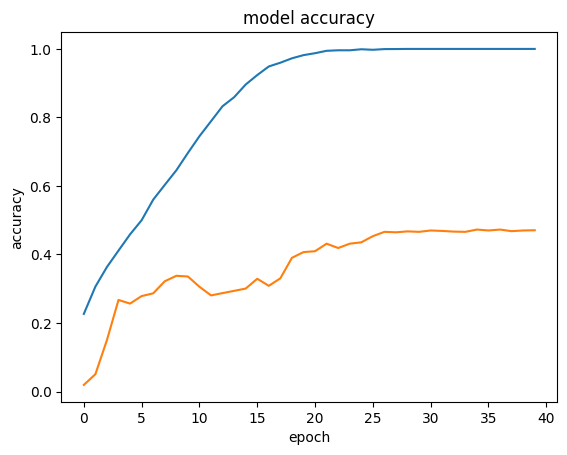

In [27]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

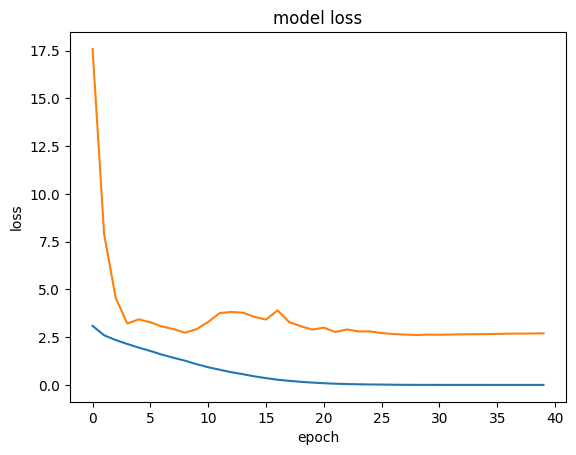

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [29]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
14/14 [==============================] - 3s 43ms/step - loss: 2.7499 - accuracy: 0.4838
Test loss: 2.7498631477355957
Test accuracy: 0.48383232951164246


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [32]:

def predict_author(img):
    # 寫個單圖片模型預測 function
    # input : opencv img (height,width,3)
    # output : 某個作家名字 E.g. Claude_Monet
    #
    # 參考步驟:
    # 1. expand img dimension (height,width,3) -> (1,height,width,3)
    # 2. 丟入模型 model.predict
    # 3. 取出 softmax 後 (50,) 取最大值的 index 作為辨識結果
    # 4. 將辨識結果轉為畫作家名字

    author_name = ""
    author_name = ""
    
    img = np.expand_dims(img, axis=0)

    # Make a prediction
    pred = model.predict(img)
    # Get the predicted class label
    label = np.argmax(pred[0])
    author_name = rev_class_name[label]

    return author_name

In [33]:
plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    plt.title(
        "True Author : {} \nPred Author : {}".format(
            "_".join(imgName.split("_")[:-1]), predict_author(img)
        ),
        size=11,
    )

1/1 [==============================] - 0s 28ms/step


* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [35]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img)))
    plt.axis("off")
    plt.show()

Saving Albrecht_Du_rer_1.jpg to Albrecht_Du_rer_1.jpg
1/1 [==============================] - 0s 38ms/step


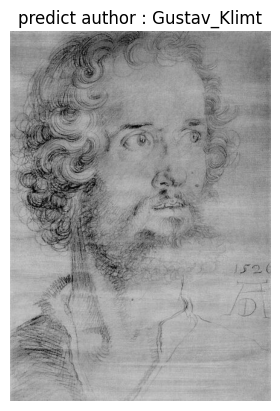

In [36]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()